In [1]:
import ast
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import face_recognition
from tqdm.auto import tqdm
from PIL import Image

import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly
import plotly.express as px
import plotly.figure_factory as ff

plotly.offline.init_notebook_mode(connected=True)

In [2]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [3]:
files = [x for x in Path('./data/images').iterdir()]
files[0]

PosixPath('data/images/S02E04_54096_0.png')

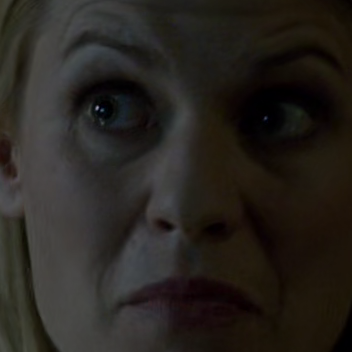

In [4]:
img = Image.open(str(files[0]))
img

In [5]:
frame = cv2.imread(str(files[0]))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w = frame.shape[:2]
print(h, w)

352 352


In [6]:
encoding = face_recognition.face_encodings(frame_rgb, known_face_locations=[[0, w, h, 0]])
encoding

[array([-0.08064506,  0.07720829,  0.03460339, -0.06953639, -0.10354945,
        -0.06427184,  0.03810081, -0.12635426,  0.24110678, -0.09772904,
         0.15118338,  0.03994111, -0.42150888,  0.01945598, -0.02423538,
         0.17507312, -0.14027648, -0.19392651, -0.15611458, -0.07657824,
         0.02840302,  0.07206324,  0.07907905,  0.05118173, -0.1045636 ,
        -0.30027723, -0.0695474 , -0.01773133, -0.01653698, -0.03051784,
         0.01580612,  0.08931477, -0.14408785, -0.00396243,  0.1004016 ,
         0.09438184, -0.08604945, -0.17003359,  0.24996109,  0.01807702,
        -0.22524349, -0.09810624,  0.01545068,  0.2367634 ,  0.24375188,
        -0.09146851,  0.06287474, -0.14333756,  0.14860353, -0.3638553 ,
         0.05570682,  0.17732565,  0.04061519,  0.02068215,  0.14153109,
        -0.19705695,  0.00213297,  0.24524754, -0.21384682,  0.0013975 ,
         0.1273289 , -0.12166226, -0.10520086, -0.13009663,  0.1789237 ,
         0.08802234, -0.21030587, -0.1350098 ,  0.2

In [7]:
df = pd.read_csv('./data/faces.csv', index_col=0)
df.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0..."
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0..."
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0..."
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0...."
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0..."


In [8]:
# fig = ff.create_distplot([df['pct_of_frame'].values], ['distplot'])
# plotly.offline.iplot(fig)

In [9]:
a = df.shape[0]
print(a)
faces_df = df[df['pct_of_frame'] >= 0.05]
b = faces_df.shape[0]
print(b)
print(a - b)

249535
98062
151473


In [10]:
episode_df = pd.read_csv('./data/episodes.csv', index_col=0)
faces_df = faces_df.merge(episode_df[['imdb_id', 'cast']],
              on='imdb_id',
              how='left'
             )
faces_df.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast
0,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...","0000132,0507073,1072555,0362873,1459109,209313..."
1,1811020,384,0,497,208,849,560,1080,1920,123904,0.060,1,1,"[-0.09047424793243408, 0.08664017170667648, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
2,1811020,408,0,390,208,742,560,1080,1920,123904,0.060,1,1,"[-0.15323874354362488, 0.10863395780324936, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
3,1811020,432,0,198,99,807,707,1080,1920,370272,0.179,1,1,"[-0.1460844725370407, 0.09071134030818939, 0.0...","0000132,0507073,1072555,0362873,1459109,209313..."
4,1811020,456,0,445,160,1053,769,1080,1920,370272,0.179,1,1,"[-0.11816225200891495, 0.12249065190553665, 0....","0000132,0507073,1072555,0362873,1459109,209313..."


In [11]:
episode = faces_df[(faces_df['season'] == 1) 
                    & (faces_df['episode'] == 2)
]
print(episode.info())
episode.head()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 1290 to 2082
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   imdb_id       793 non-null    int64  
 1   frame_num     793 non-null    int64  
 2   face_num      793 non-null    int64  
 3   x1            793 non-null    int64  
 4   y1            793 non-null    int64  
 5   x2            793 non-null    int64  
 6   y2            793 non-null    int64  
 7   img_height    793 non-null    int64  
 8   img_width     793 non-null    int64  
 9   area          793 non-null    int64  
 10  pct_of_frame  793 non-null    float64
 11  season        793 non-null    int64  
 12  episode       793 non-null    int64  
 13  encoding      793 non-null    object 
 14  cast          793 non-null    object 
dtypes: float64(1), int64(12), object(2)
memory usage: 99.1+ KB
None


,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast
1290,1988308,72,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.12935210764408112, 0.09023398905992508, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
1291,1988308,96,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.15715254843235016, 0.05274084210395813, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
1292,1988308,120,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.12813544273376465, 0.02122906967997551, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
1293,1988308,144,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.1354607343673706, 0.04214496165513992, 0.0...","0000132,0507073,1072555,0362873,1459109,209313..."
1294,1988308,168,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.14760874211788177, 0.03259202465415001, 0....","0000132,0507073,1072555,0362873,1459109,209313..."


In [12]:
data = []
for file in tqdm(files):
    temp, frame_num, face_num = file.stem.split('_')
    s = int(temp[1:3])
    e = int(temp[4:6])
    datum = {'fp': str(file.absolute().resolve()),
             'season': s,
             'episode': e,
             'frame_num': int(frame_num),
             'face_num': int(face_num)
            }
    data.append(datum)
fp_df = pd.DataFrame(data)
fp_df.head()

  0%|          | 0/249535 [00:00<?, ?it/s]

,fp,season,episode,frame_num,face_num
0,/home/amos/programs/FacesOfHomeland/data/image...,2,4,54096,0
1,/home/amos/programs/FacesOfHomeland/data/image...,7,1,74904,0
2,/home/amos/programs/FacesOfHomeland/data/image...,3,6,60000,0
3,/home/amos/programs/FacesOfHomeland/data/image...,7,2,74520,0
4,/home/amos/programs/FacesOfHomeland/data/image...,8,4,44112,1


In [13]:
episode_fp = episode.merge(fp_df,
                        on=['frame_num', 'face_num', 'season', 'episode'],
                        how='inner')
episode_fp.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast,fp
0,1988308,72,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.12935210764408112, 0.09023398905992508, 0....","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
1,1988308,96,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.15715254843235016, 0.05274084210395813, 0....","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
2,1988308,120,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.12813544273376465, 0.02122906967997551, 0....","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
3,1988308,144,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.1354607343673706, 0.04214496165513992, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
4,1988308,168,0,850,52,1902,1080,1080,1920,1081456,0.522,1,2,"[-0.14760874211788177, 0.03259202465415001, 0....","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...


In [14]:
def scatter_thumbnails(data, images, scale_factor=16, colors=None, show_images=True):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data

    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    if show_images:
        # add thumbnails :)
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox
        for i in tqdm(range(len(images))):
            image = plt.imread(images[i])
            h, w = image.shape[:2]
            n_h = int(h/scale_factor)
            n_w = int(w/scale_factor)
            image = cv2.resize(image, (n_w, n_h))
            outputImage = cv2.copyMakeBorder(
                 image, 
                 10, 
                 10, 
                 10, 
                 10, 
                 cv2.BORDER_CONSTANT, 
                 value=colors[i] if colors is not None else None)
            im = OffsetImage(image)
            bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
            ab = AnnotationBbox(im, x[i], xycoords='data',
                                frameon=(bboxprops is not None),
                                pad=0.1,
                                bboxprops=bboxprops)
            ax.add_artist(ab)
    return ax

In [15]:
data = np.array([np.array(ast.literal_eval(x)) for x in episode_fp['encoding'].tolist()])
faces = episode_fp['fp'].tolist()

In [16]:
# _ = scatter_thumbnails(data, faces)
# plt.title('PCA')
# plt.show()

## TSNE

In [17]:
%%time
from sklearn.manifold import TSNE
# PCA first to speed it up
x = PCA(n_components='mle', svd_solver='full').fit_transform(data)
tsne = TSNE(perplexity=50,
         n_components=2,
         learning_rate='auto',
         n_iter=2000,
         early_exaggeration=24.0)
x = tsne.fit_transform(x)
ax = scatter_thumbnails(x, faces, zoom=1.0, show_images=True)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()
ax = None

TypeError: scatter_thumbnails() got an unexpected keyword argument 'zoom'

In [18]:
def get_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.max(labels) + 1)
    colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
    return labels, colors

In [19]:
for i in range(2, 10, 1):
    for j in np.arange(0.1, 1.0, 0.1):
        labels, colors = get_clusters(x, faces, cluster.DBSCAN, n_jobs=-1, eps=j, min_samples=i)
        episode_fp['cluster'] = labels
        print(i, j, len(list(set(labels))))

TypeError: 'list' object is not callable

In [20]:
x = PCA(n_components='mle', svd_solver='full').fit_transform(data)
x = TSNE(perplexity=50,
         n_components=2,
         learning_rate='auto',
         n_iter=2000,
         early_exaggeration=12.0).fit_transform(x)

labels, colors = get_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=3.5, min_samples=12)
episode_fp['cluster'] = labels
print(list(set(labels)))

[0, 1, 2, 3, 4, 5, 6, 7, -1]


  0%|          | 0/793 [00:00<?, ?it/s]

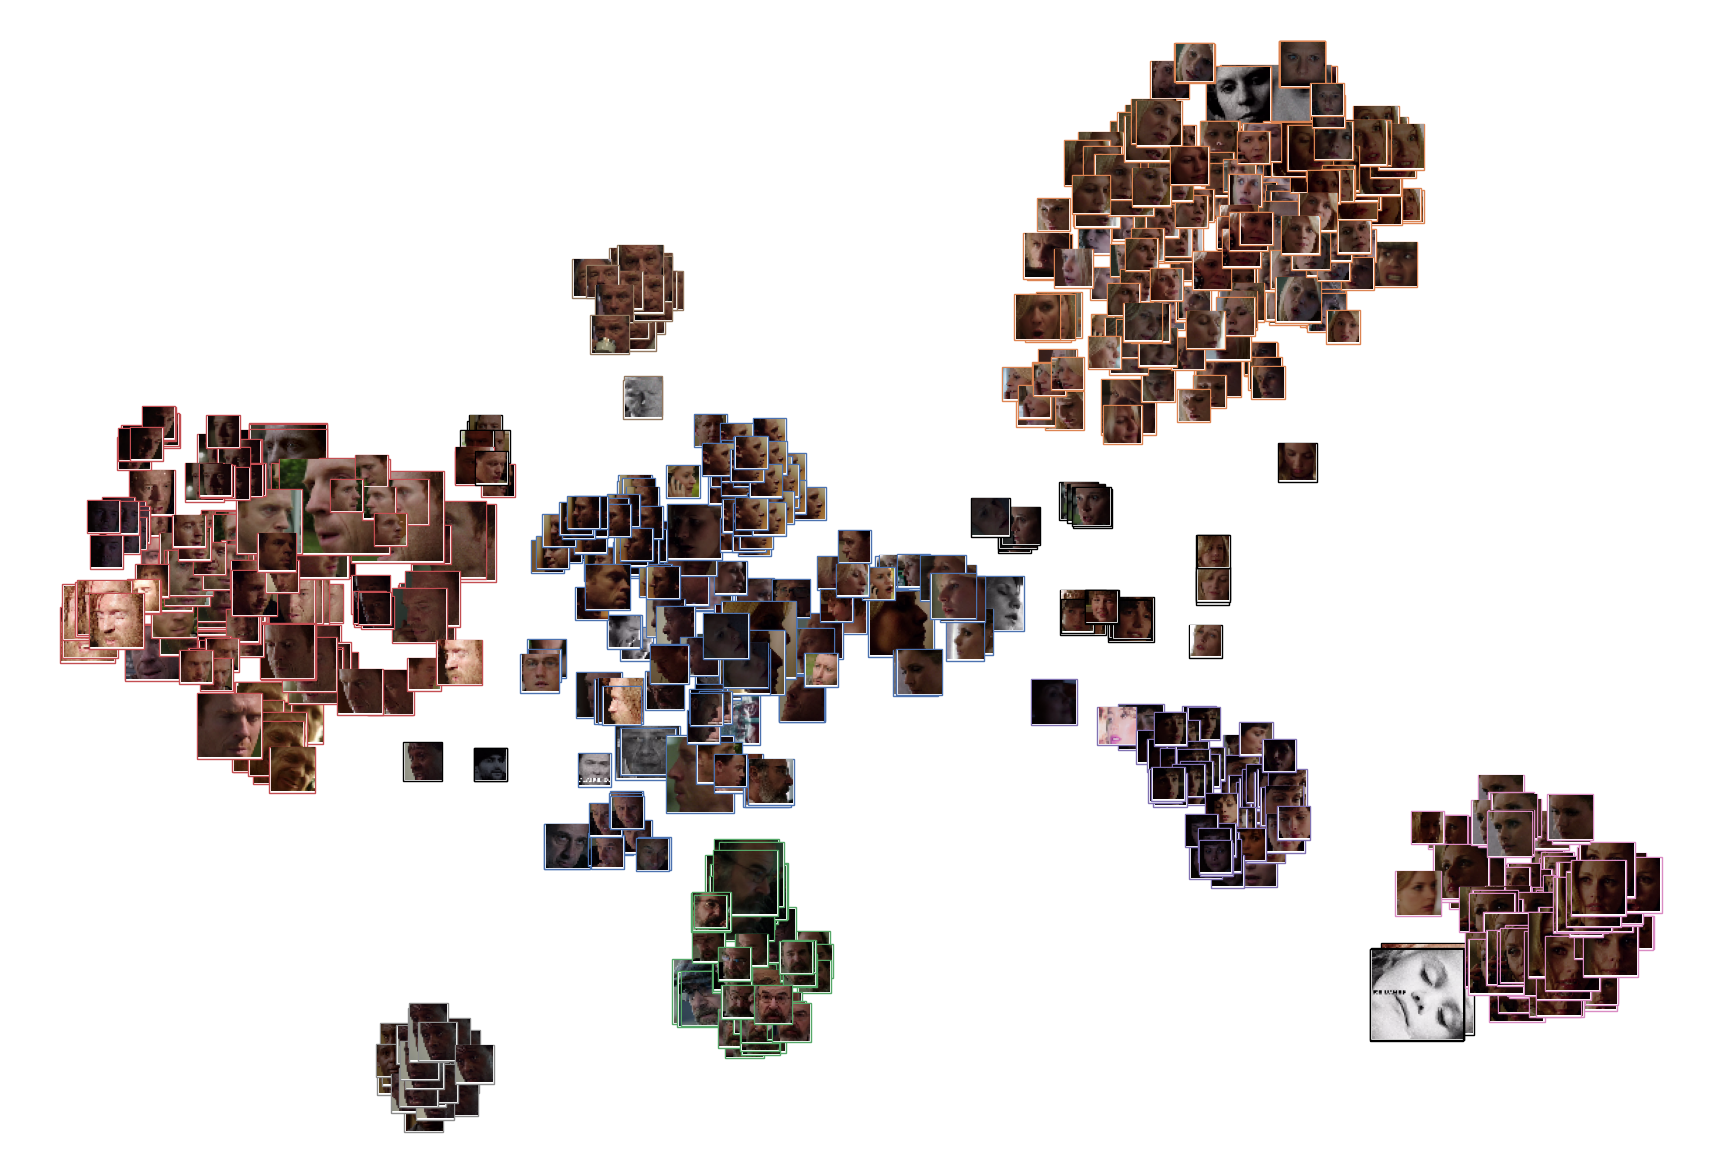

In [21]:
ax = scatter_thumbnails(x, faces, scale_factor=16, colors=colors, show_images=True)

In [37]:
x = PCA(n_components=2).fit_transform(data)
x = TSNE(perplexity=50,
         n_components=2,
         learning_rate='auto',
         n_iter=1000,
         early_exaggeration=12.0).fit_transform(x)
labels, colors = get_clusters(x,
                              cluster.HDBSCAN,
                              n_jobs=-1,
                              store_centers='medoid',
                              # min_cluster_size=15, 
                              min_samples=5,
                              cluster_selection_epsilon=1.25,
                              cluster_selection_method='leaf',
                              leaf_size=1)
episode_fp['cluster'] = labels
print(list(set(labels)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]


  0%|          | 0/793 [00:00<?, ?it/s]

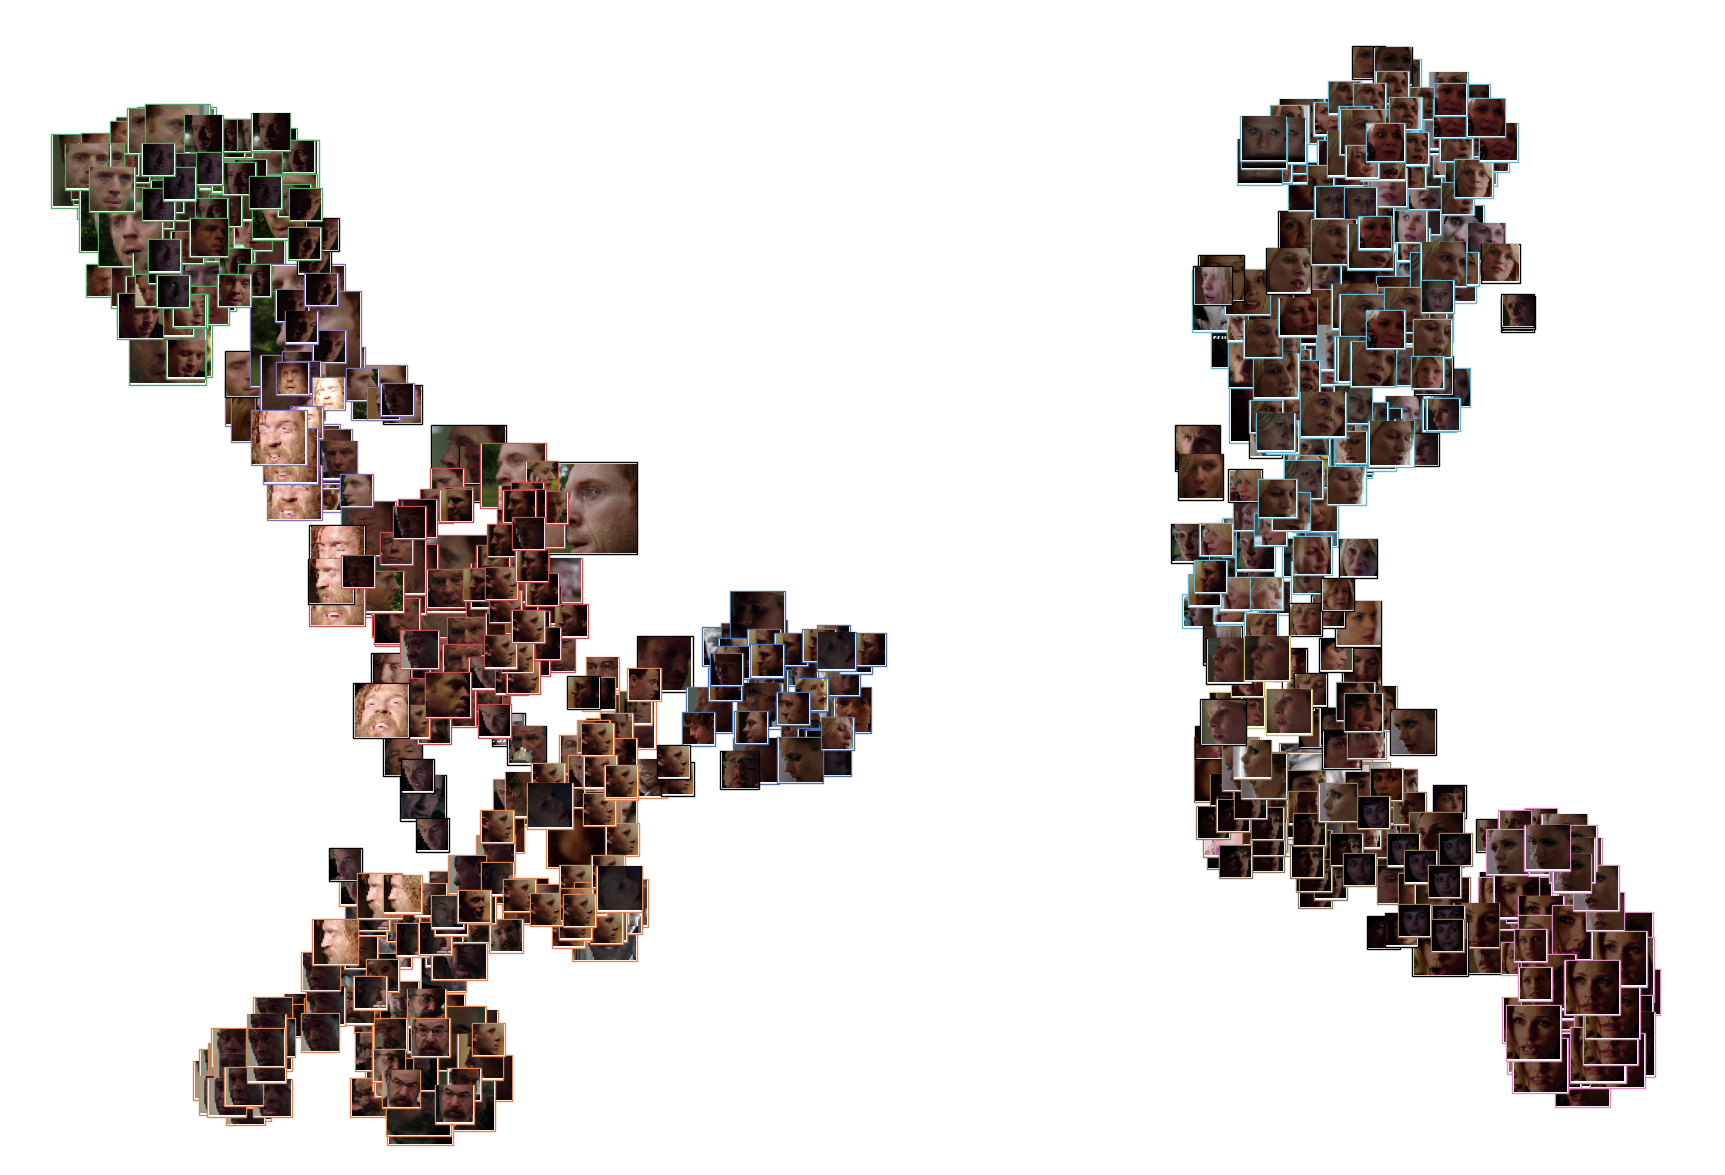

In [38]:
ax = scatter_thumbnails(x, faces, scale_factor=16, colors=colors, show_images=True)

In [81]:
x.medoids_

AttributeError: 'numpy.ndarray' object has no attribute 'medoids_'

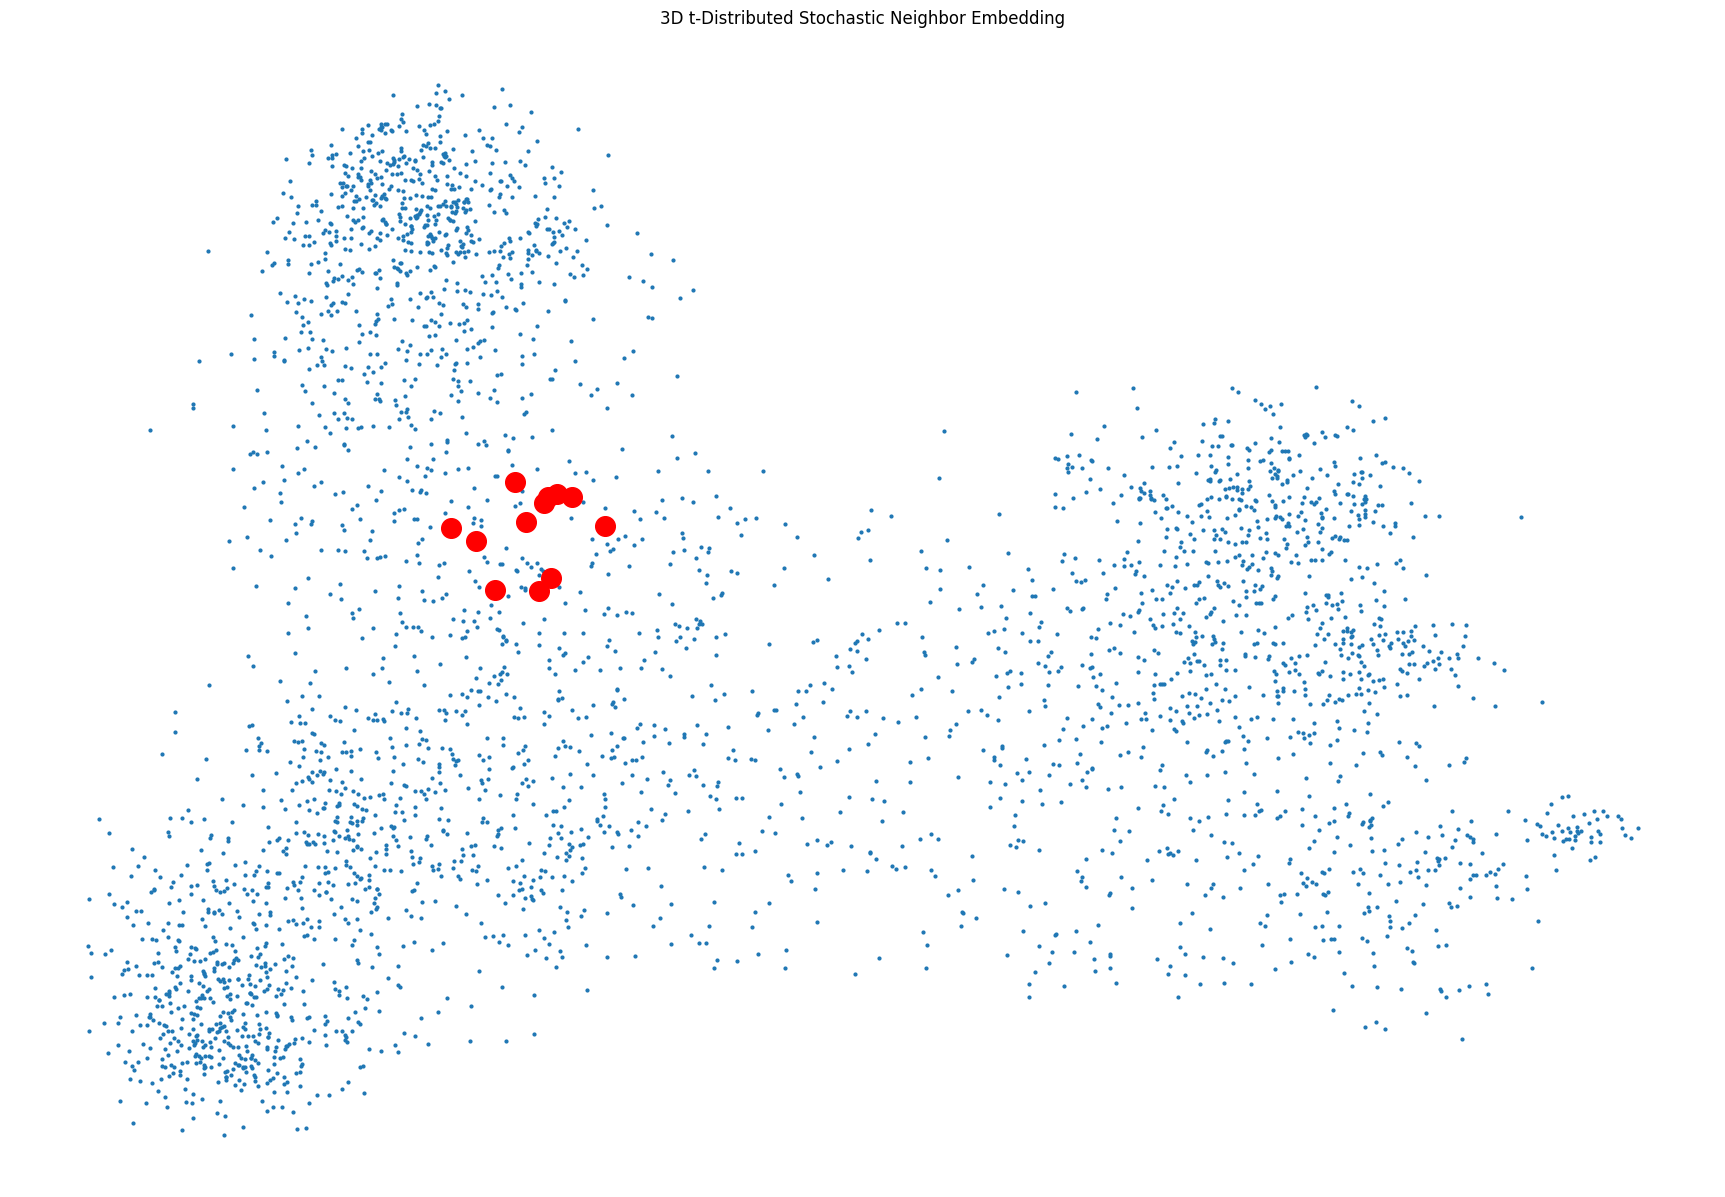

In [48]:
n_clusters = len(list(episode_fp.iloc[0]['cast'].split(',')))

kmeans = cluster.KMeans(n_clusters=12,
                        n_init=20,
                        max_iter=600)
x = PCA(n_components='mle', svd_solver='full').fit_transform(data)
x = TSNE(perplexity=50,
         n_components=2,
         learning_rate='auto',
         n_iter=2000,
         early_exaggeration=12.0).fit_transform(x)
x = kmeans.fit_transform(data)
ax = scatter_thumbnails(x, faces, zoom=1.0, show_images=False)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200)
plt.show()

In [45]:
faces_df.iloc[0]['encoding']

'[-0.1460844725370407, 0.09071134030818939, 0.06699569523334503, -0.08379890769720078, -0.11114765703678131, -0.02819160744547844, -0.06336769461631775, -0.10962036997079849, 0.26179248094558716, -0.1292765736579895, 0.15137474238872528, 0.041658416390419006, -0.26841098070144653, 0.0042415037751197815, -0.04199293255805969, 0.12966033816337585, -0.14869345724582672, -0.19770626723766327, -0.16326749324798584, -0.11486416310071945, -0.02232961356639862, 0.05375991761684418, 0.048277515918016434, 0.02583838626742363, -0.16514205932617188, -0.22339573502540588, -0.0966147854924202, -0.09256801009178162, 0.04207009822130203, -0.14453938603401184, 0.0372471883893013, 0.10035210847854614, -0.16340182721614838, -0.017567677423357964, 0.004262018948793411, 0.11894170194864273, -0.03805219754576683, -0.06406895816326141, 0.171891987323761, -0.07694067060947418, -0.25894755125045776, -0.0394158661365509, 0.05879669263958931, 0.2521434724330902, 0.27236494421958923, -0.053550202399492264, 0.0196